# House pricing

## Contents:<a class="anchor" id="0-bullet"></a>
* [1. Import libraries and download dataset](#1-bullet)
* [2. Data Analysis](#2-bullet)
  * [2.1 Analyze target](#2.1-bullet)
  * [2.2 Analyze features](#2.2-bullet)
    * [2.2.1 Visualize data/fill NaN](#2.2.1-bullet)
    * [2.2.2 Generate new features](#2.2.2-bullet)
* [3. Pretrain to fill missed target values](#3-bullet)
* [4. Clustering](#4-bullet)
* [5. Label encoding](#5-bullet)
* [6. Model](#6-bullet)
* [7. Submit](#7-bullet)

## Import libraries and download dataset<a class="anchor" id="1-bullet"></a>
[back to contents](#0-bullet)

In [1]:
#preprocessing/data analysis/visualization
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pprint
from scipy import stats
from scipy.stats import skew, norm

import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#model
import optuna
import xgboost as xgb
from optuna.samplers import TPESampler
import catboost
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score, RepeatedStratifiedKFold

In [3]:
#classtering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

In [4]:
df_train = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('./house-prices-advanced-regression-techniques/test.csv')

In [5]:
df_train.shape

(1460, 81)

In [6]:
df_test.shape

(1459, 80)

In [7]:
# Merge train and test
df = pd.concat([df_train, df_test], axis=0)
df = df.reset_index()
df.drop(['Id', 'index'], axis=1, inplace=True)
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


In [8]:
# Create new variable
df['train'] = df['SalePrice'].apply(lambda x: 1 if x>0 else 0)

In [9]:
#check
df[df['train'].isin([0])].shape, df[df['train'].isin([1])].shape

((1459, 81), (1460, 81))

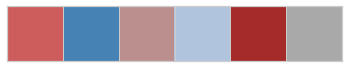

In [10]:
# Set project colors
colors = ['indianred', 'steelblue', 'rosybrown', 'lightsteelblue','brown', 'darkgrey']
sns.palplot(sns.color_palette(colors))

## Data Analysis<a class="anchor" id="2-bullet"></a>
[back to contents](#0-bullet)

### Analyze target<a class="anchor" id="2.1-bullet"></a>

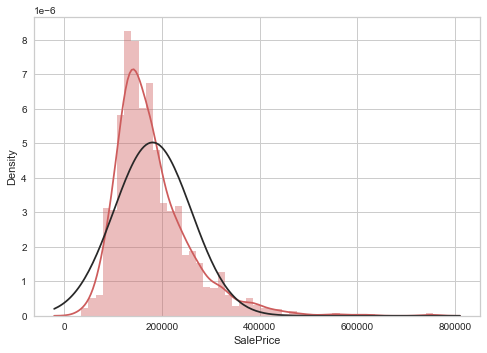

In [11]:
sns.distplot(df['SalePrice'], kde = True, hist=True, fit = norm, color=colors[0]);

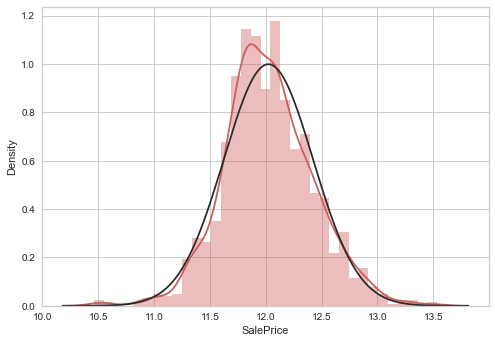

In [19]:
# logarithm the target to normalize it
sns.distplot(np.log(df['SalePrice']), kde = True, hist=True, fit = norm, color=colors[0]);

### Analyze features<a class="anchor" id="2.2-bullet"></a>
[back to contents](#0-bullet)

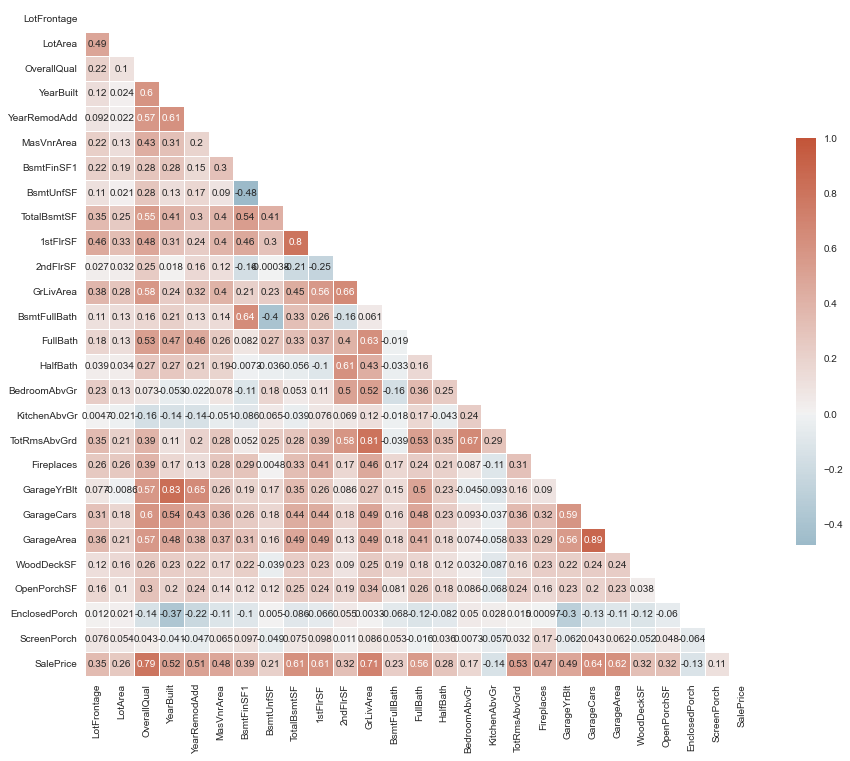

In [20]:
f, ax = plt.subplots(figsize=(15, 15))
corrmat = df.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.1]
mat = df[top_corr_features].corr()
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"size": 10})
plt.show()

In [21]:
def type_separator(df):
    
    cat = list(df.select_dtypes(include=['object']).columns)
    nums = list(df.select_dtypes(exclude=['object']).columns)
    
    if df.shape[1] == len(cat + nums):
        return cat, nums   
    else: print('DataFrame have another type(not int, float, object)')

In [22]:
# get type features
cat, nums= type_separator(df)
pprint.pprint([cat, nums], compact=True, indent=1, width=80)

[['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
  'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
  'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
  'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
  'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
  'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
  'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
  'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
  'SaleCondition'],
 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
  'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
  'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
  'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
  'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
  'GarageCars', 'GarageArea', 'WoodDe

In [23]:
# count NaN
def get_nan(df):
    miss_features = df.isnull().sum().sort_values(ascending=False)
    return miss_features[miss_features > 0]

In [24]:
get_nan(df)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Utilities          2
Functional         2
BsmtFullBath       2
BsmtHalfBath       2
BsmtUnfSF          1
BsmtFinSF2         1
TotalBsmtSF        1
BsmtFinSF1         1
Electrical         1
KitchenQual        1
GarageCars         1
Exterior2nd        1
Exterior1st        1
SaleType           1
GarageArea         1
dtype: int64

### Visualize data/fill NaN<a class="anchor" id="2.2.1-bullet"></a>
[back to contents](#0-bullet)

In [25]:
def NoneFillner(df, l):
    for feature in l:
        if(isinstance(df[feature], pd.Series)):
            df[feature].fillna('None',inplace=True)
    return df[l].isnull().sum().sort_values(ascending=False)

In [26]:
None_values = ['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'FireplaceQu', 'GarageCond', 
               'GarageFinish', 'GarageQual', 'GarageType', 
              'BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1']

# Fill "None"
NoneFillner(df, None_values)

Alley           0
MasVnrType      0
PoolQC          0
Fence           0
FireplaceQu     0
GarageCond      0
GarageFinish    0
GarageQual      0
GarageType      0
BsmtCond        0
BsmtExposure    0
BsmtQual        0
BsmtFinType2    0
BsmtFinType1    0
dtype: int64

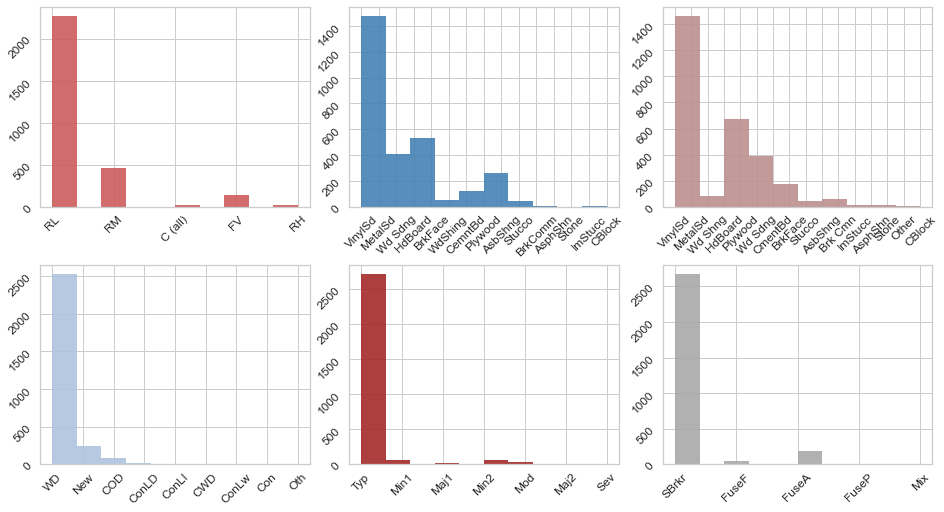

In [27]:
#Visualizing Categorical Data
fig, [(ax0, ax1, ax2), (ax3, ax4, ax5)] = plt.subplots(nrows = 2,
                                             ncols = 3, figsize=(13,7), constrained_layout=True)
df['MSZoning'].hist(ax=ax0, color=colors[0], alpha=0.9)
df['Exterior1st'].hist(ax=ax1, color=colors[1], alpha=0.9)
df['Exterior2nd'].hist(ax=ax2, color=colors[2], alpha=0.9)
df['SaleType'].hist(ax=ax3, color=colors[3], alpha=0.9)
df['Functional'].hist(ax=ax4, color=colors[4], alpha=0.9)
df['Electrical'].hist(ax=ax5, color=colors[5], alpha=0.9)

ax0.tick_params(labelrotation = 45, labelsize=12)
ax1.tick_params(labelrotation = 45, labelsize=12)
ax2.tick_params(labelrotation = 45, labelsize=12)
ax3.tick_params(labelrotation = 45, labelsize=12)
ax4.tick_params(labelrotation = 45,labelsize=12)
ax5.tick_params(labelrotation = 45,labelsize=12);

In [28]:
# fill mode
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
df['Functional'] = df['Functional'].fillna('Typ') 
df['Electrical'] = df['Electrical'].fillna("SBrkr") 
df['KitchenQual'] = df['KitchenQual'].fillna("TA") 

In [29]:
# fill in 0 numerical variables for which there are no amenities in the house
for col in ('GarageArea', 'GarageCars'):
    df[col] = df[col].fillna(0)  
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df[col] = df[col].fillna(0)
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)

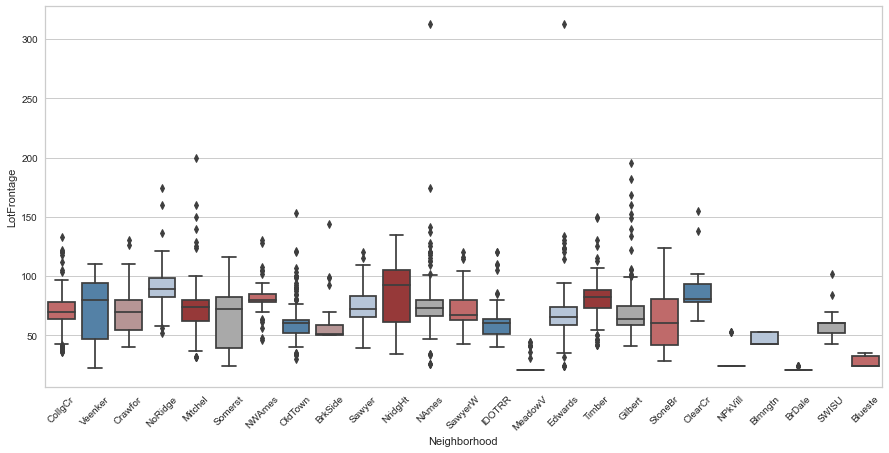

In [30]:
#The dependence of the facade of the site on the area
plt.figure(figsize=(15,7))
sns.boxplot(data=df, x='Neighborhood', y='LotFrontage', palette=colors)
plt.xticks(rotation=45);

In [31]:
# fill median
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].median())

In [32]:
# check nan
get_nan(df)

MiscFeature    2814
SalePrice      1459
Utilities         2
dtype: int64

In [33]:
#drop columns where are too much NaN and useless column
df.drop(['MiscFeature'], axis = 1, inplace=True)
df.drop('Utilities', axis = 1, inplace=True)

In [34]:
def get_num_info(col, title=None, target=None):

    title = title if title is not None else f"Distribution for '{col}"
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5),)
    
    sns.distplot(col.values, bins=20, ax=ax1, fit=norm) 
    
    fig = sm.qqplot(col, fit=False, line='45', ax=ax2)
    fig.suptitle(title, fontsize=20)
    
    ax3.boxplot(col.values,vert = False)
    
    ax4.scatter(x = col.values, y = target)

    ax1.set_title('QQ-plot')
    ax2.set_title('Distribution')
    ax3.set_title('Boxplot')
    ax4.set_title('Scatter')
    
    plt.show();

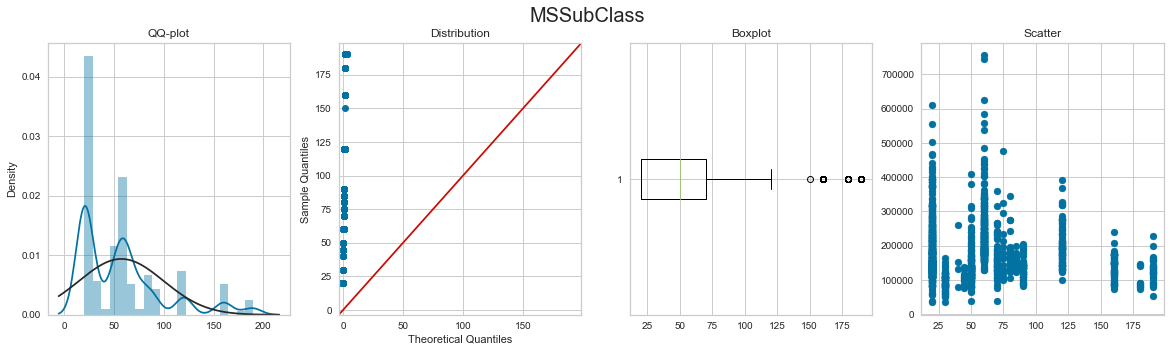

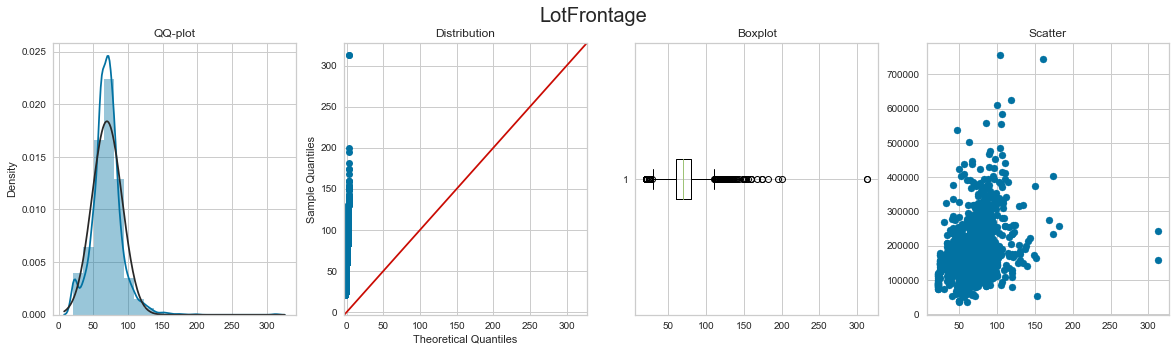

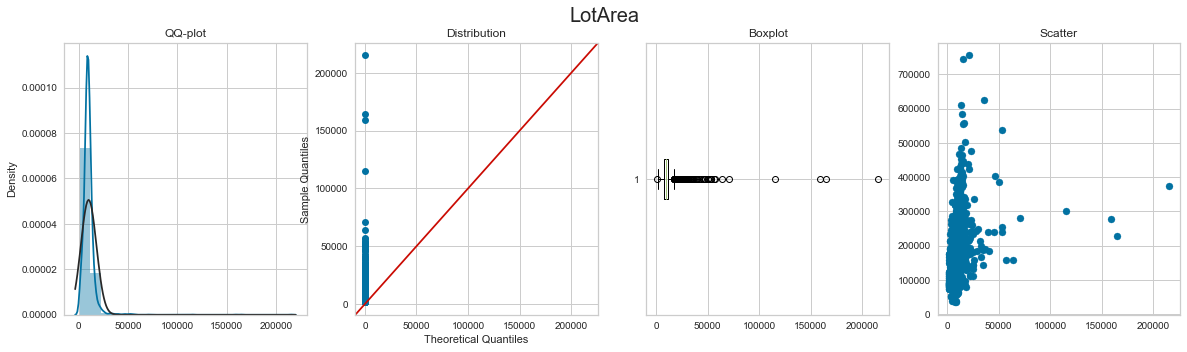

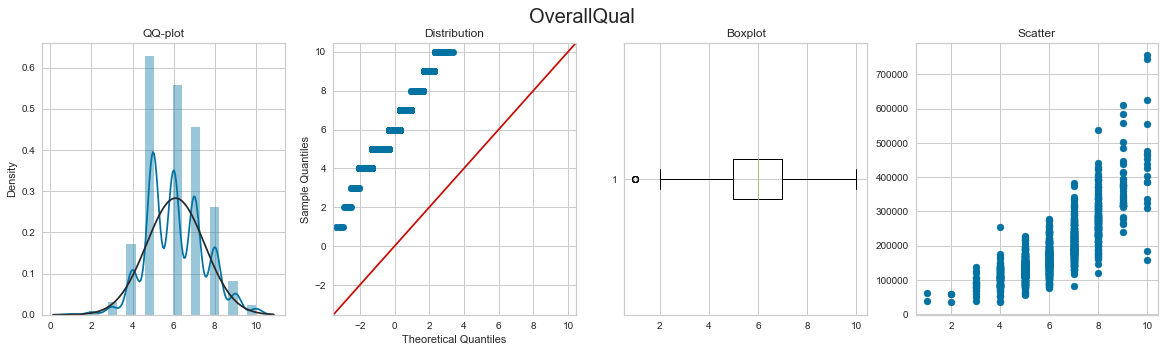

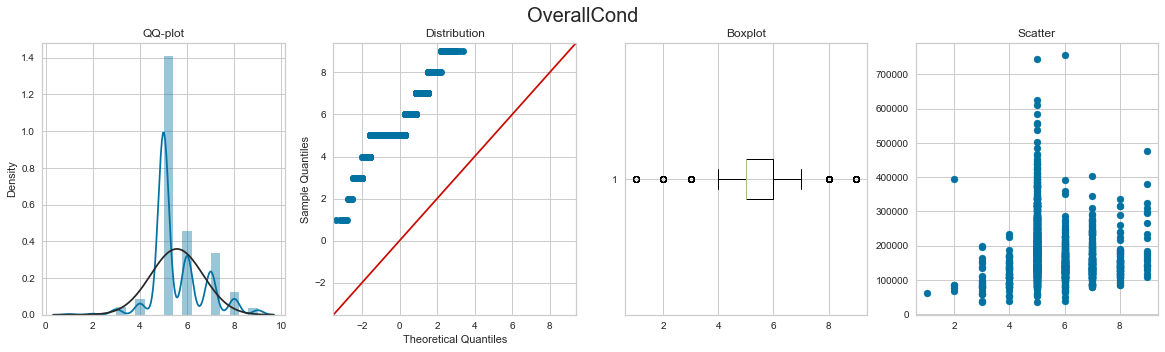

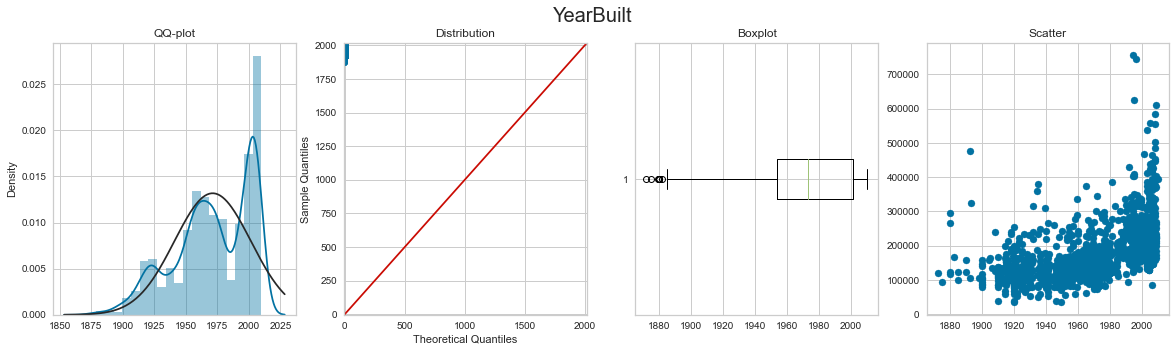

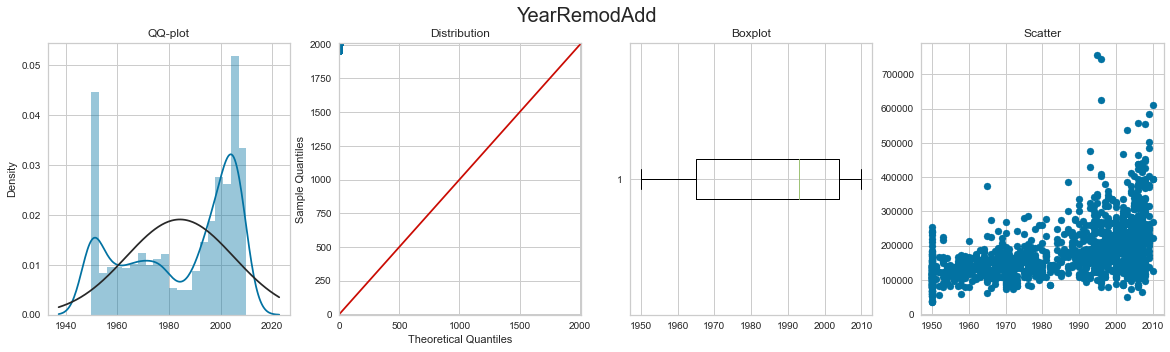

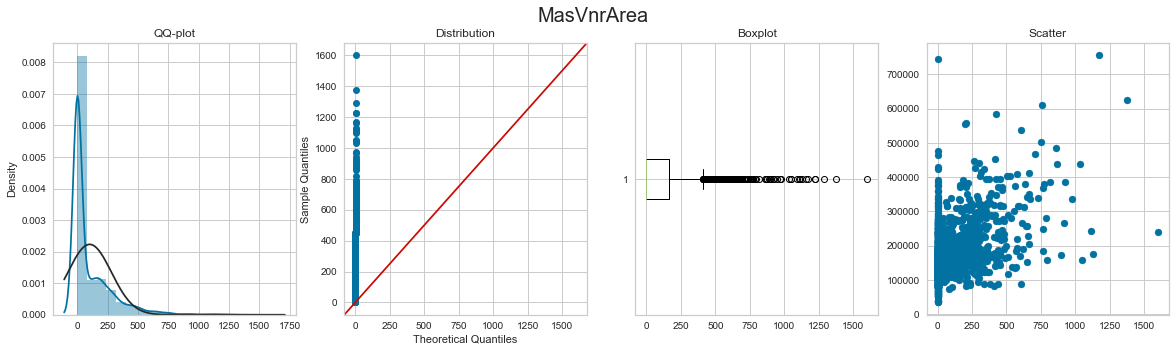

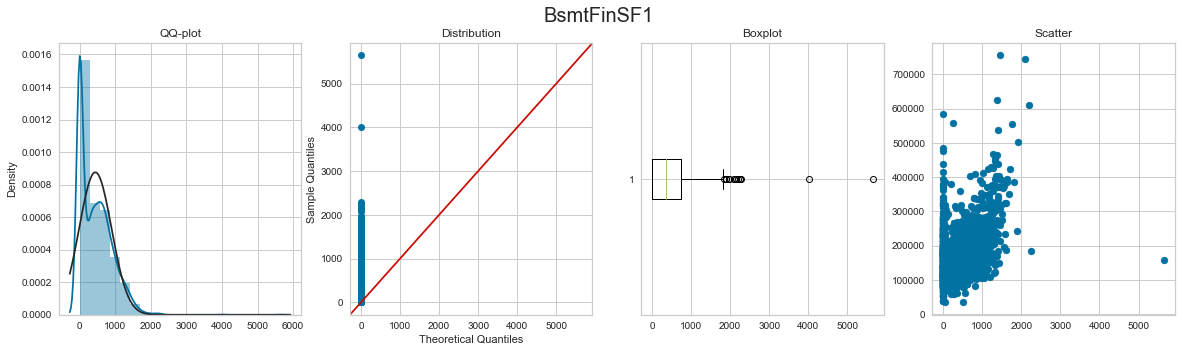

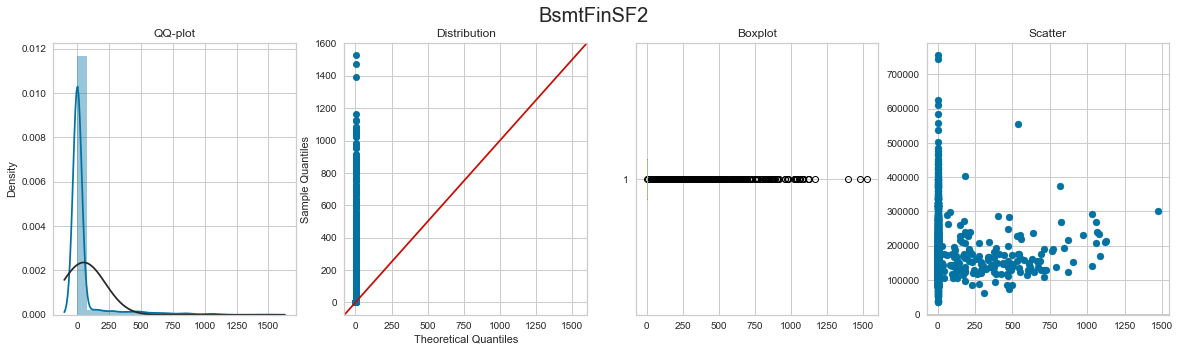

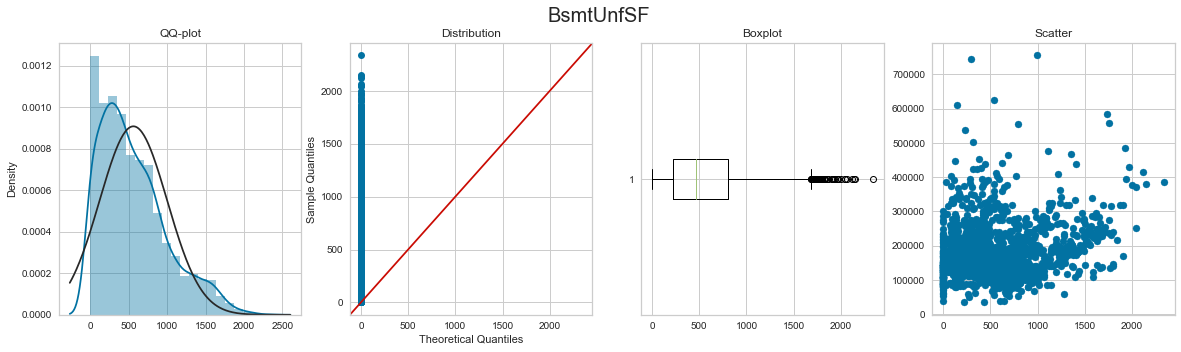

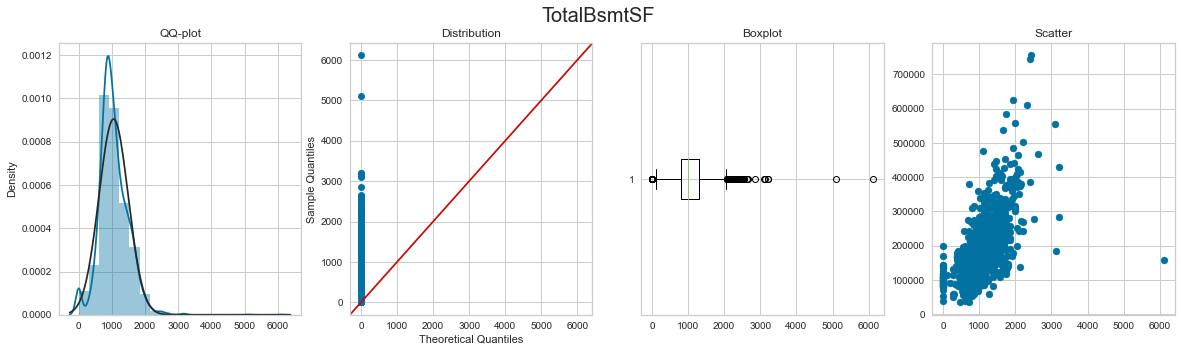

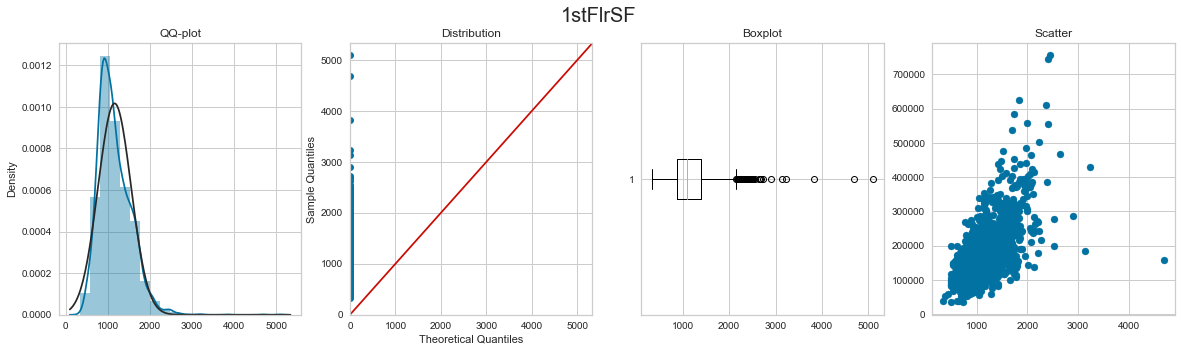

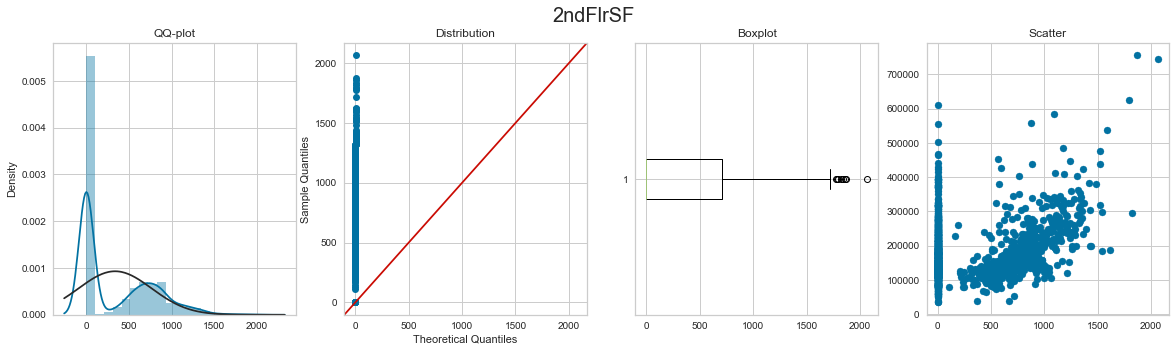

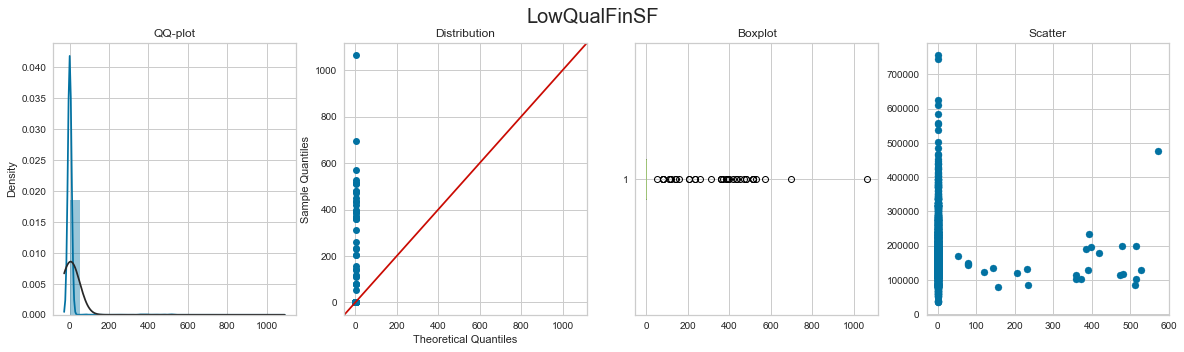

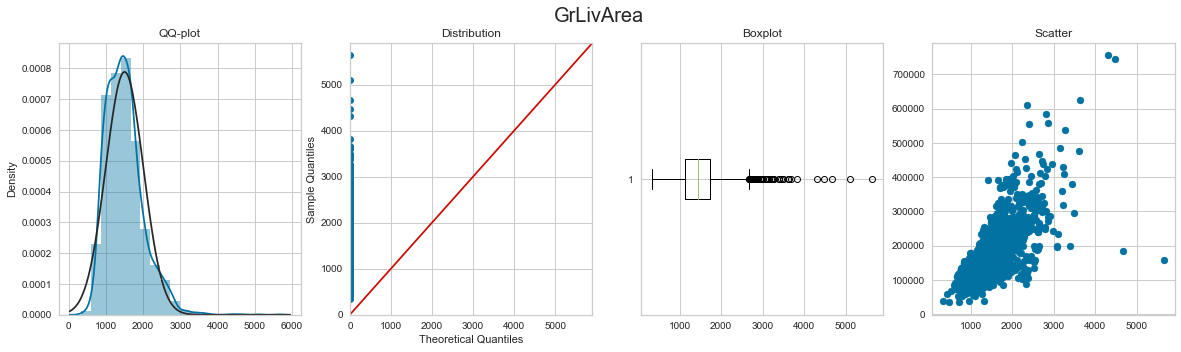

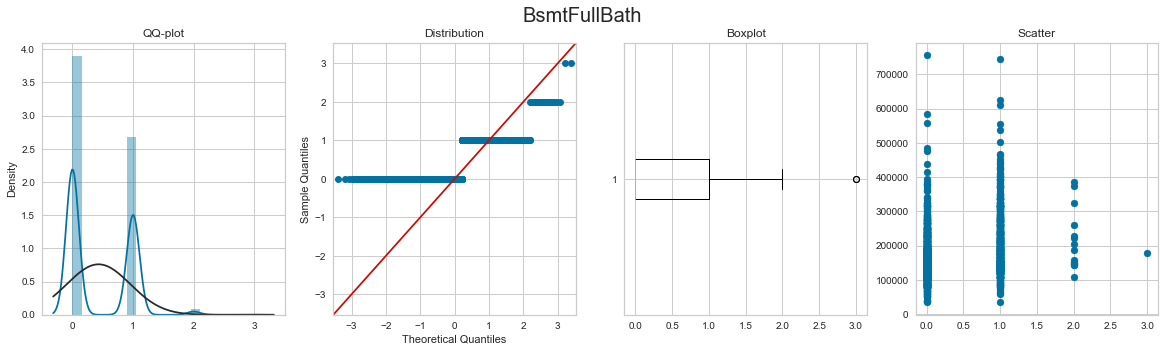

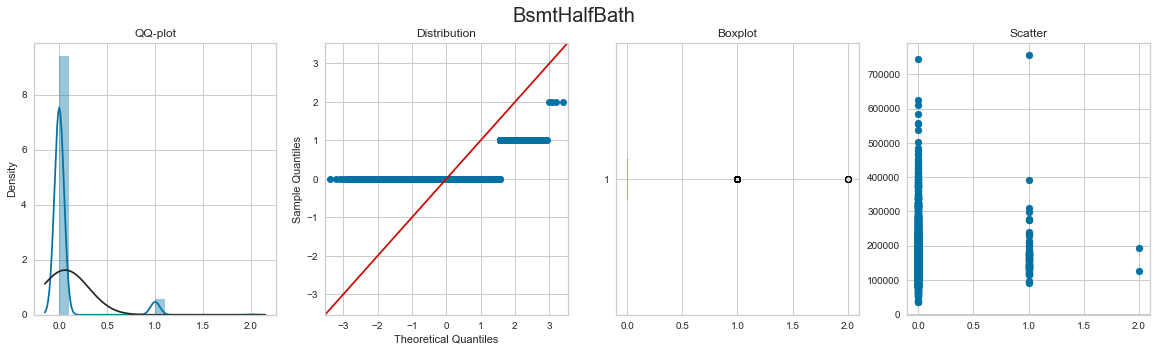

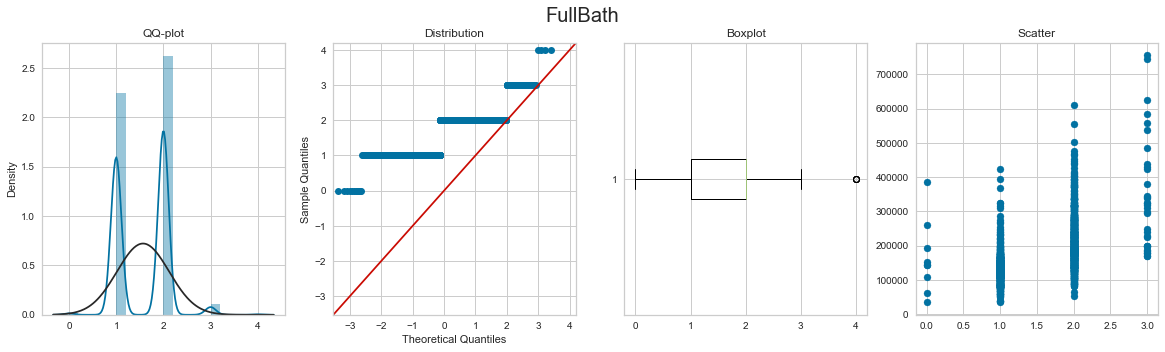

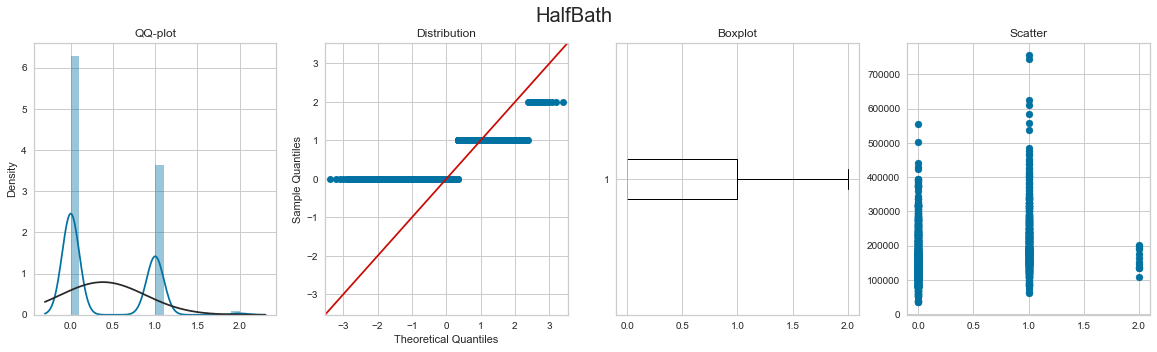

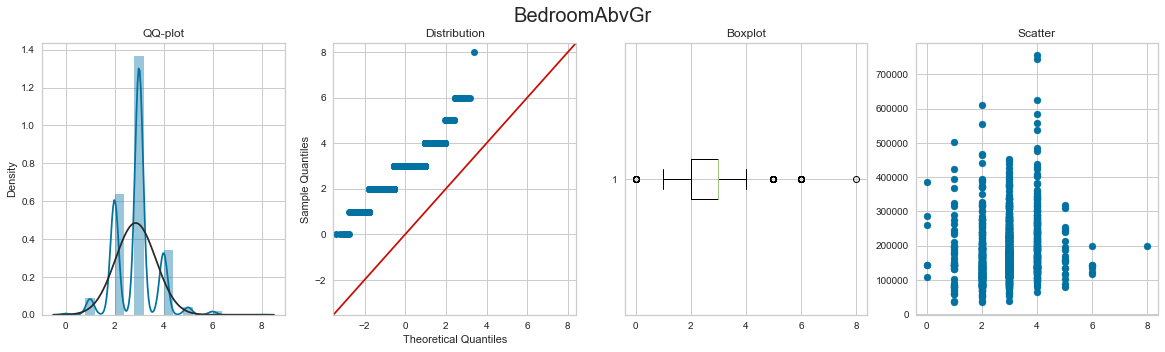

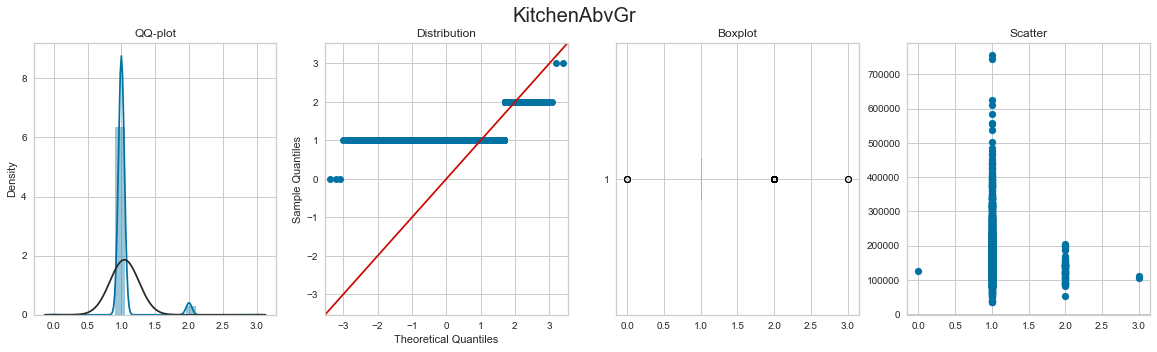

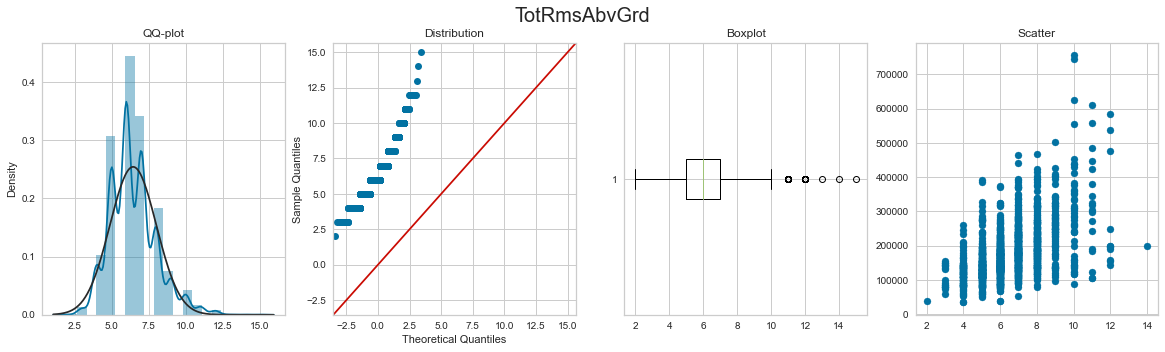

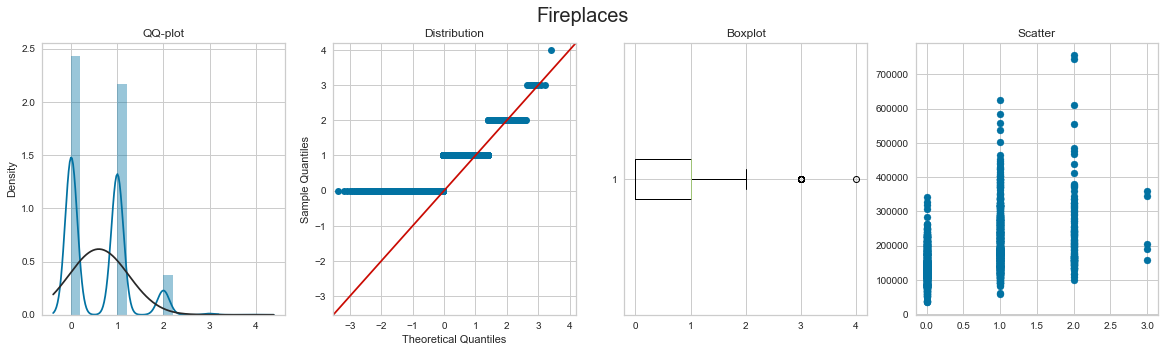

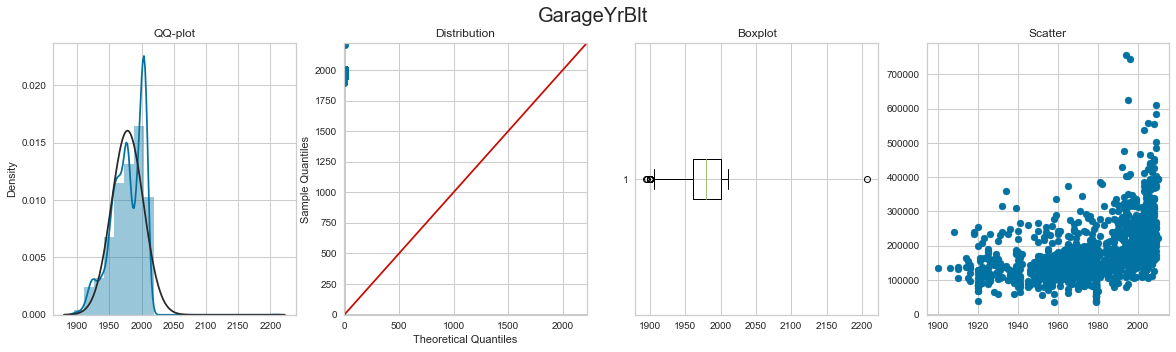

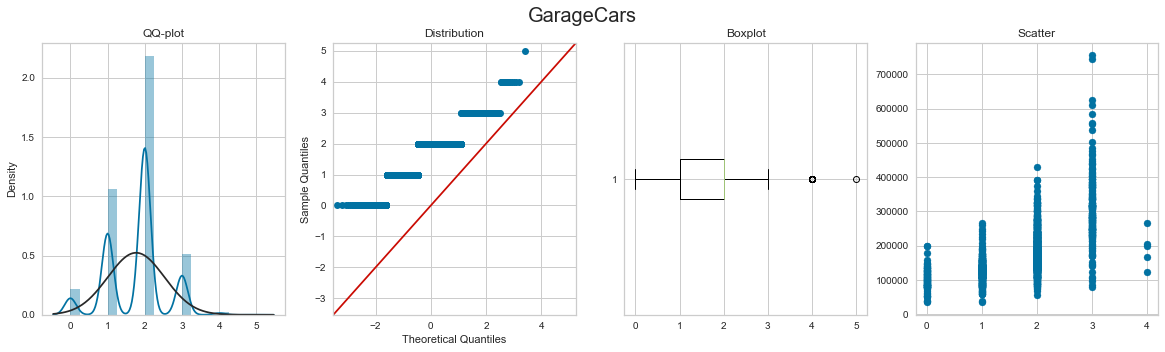

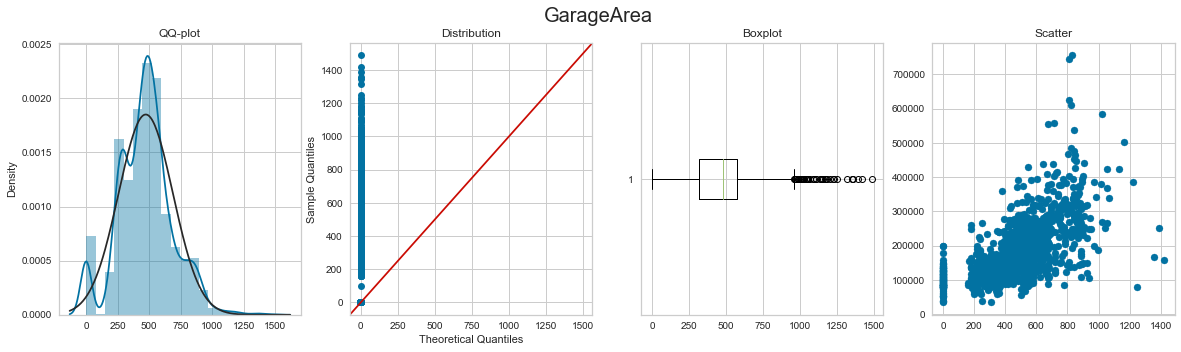

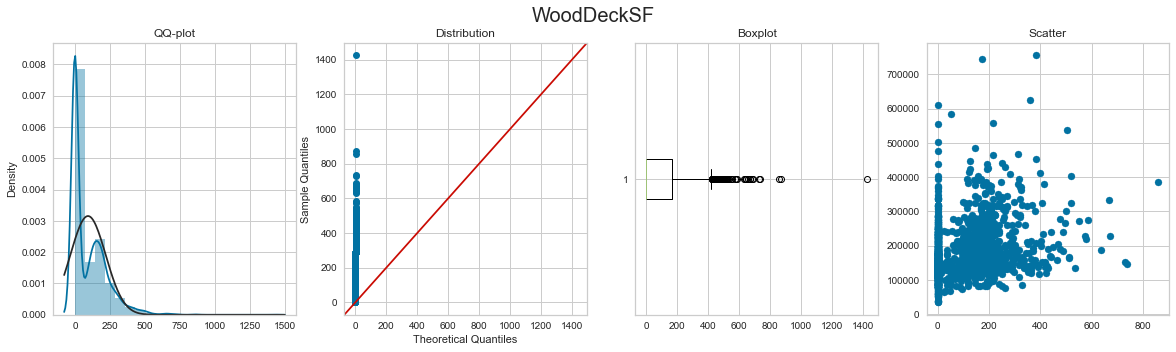

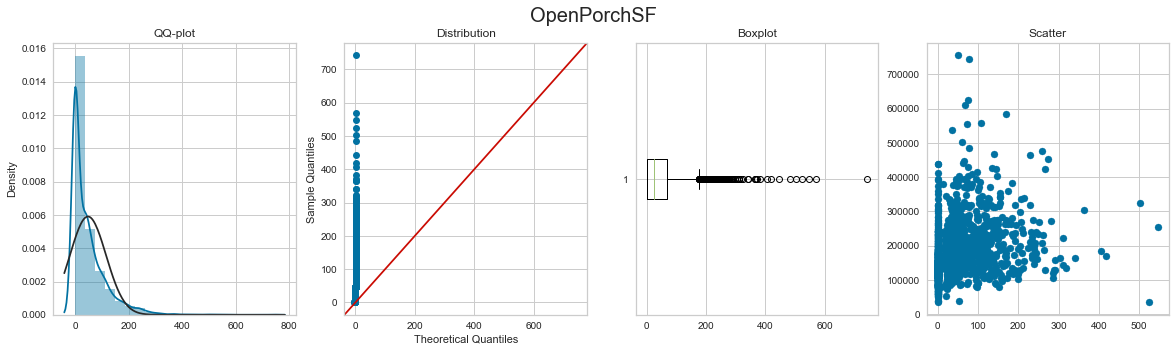

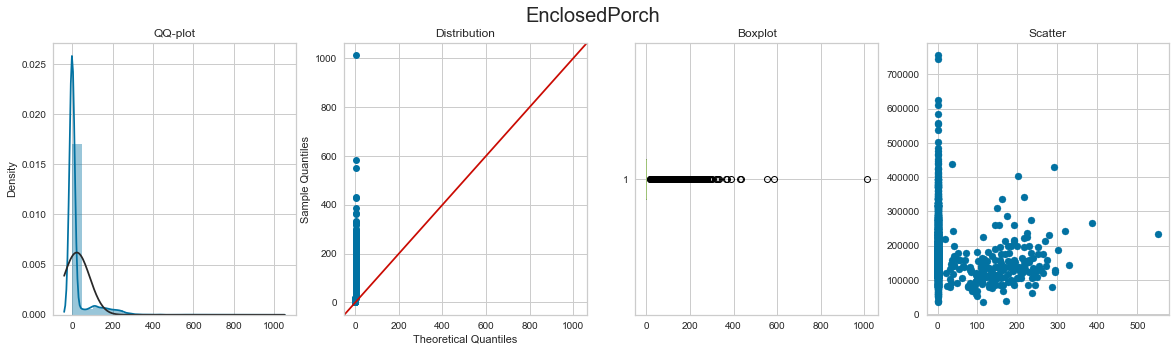

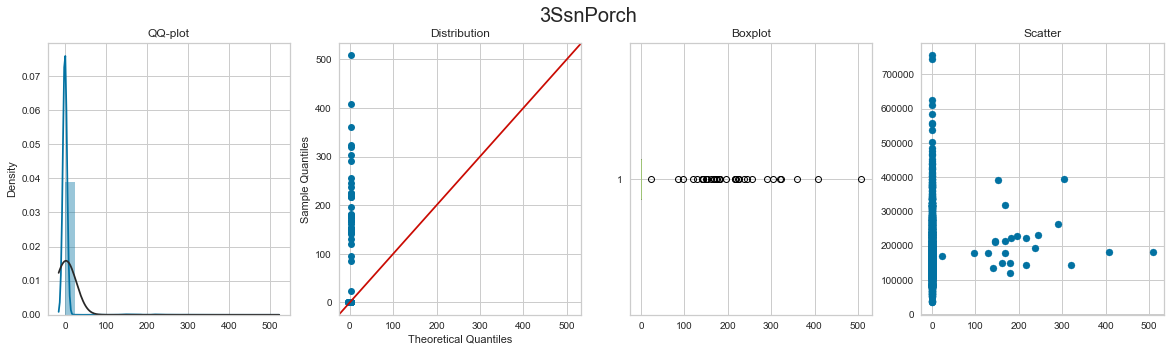

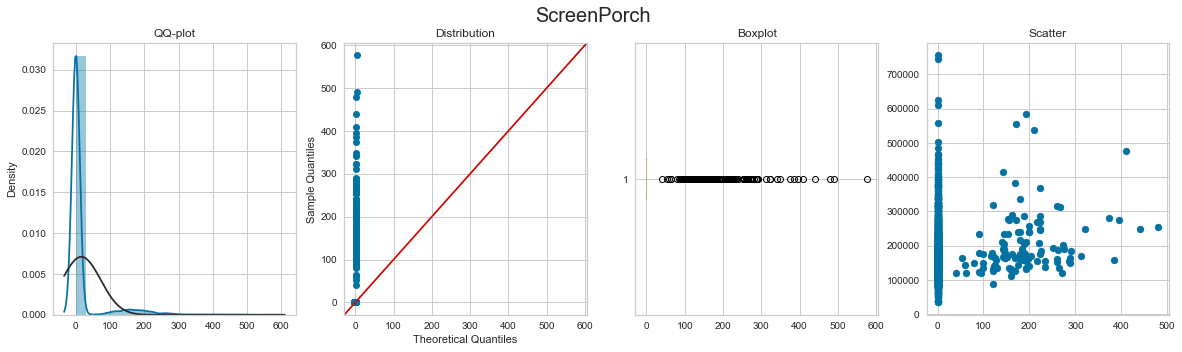

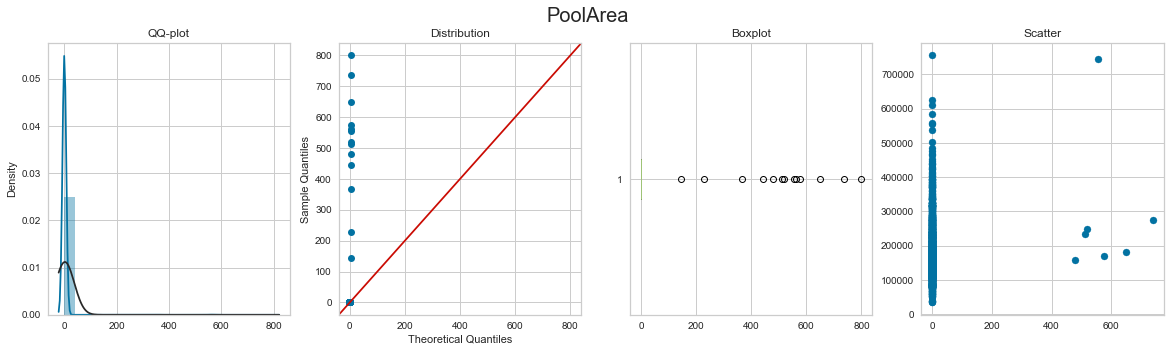

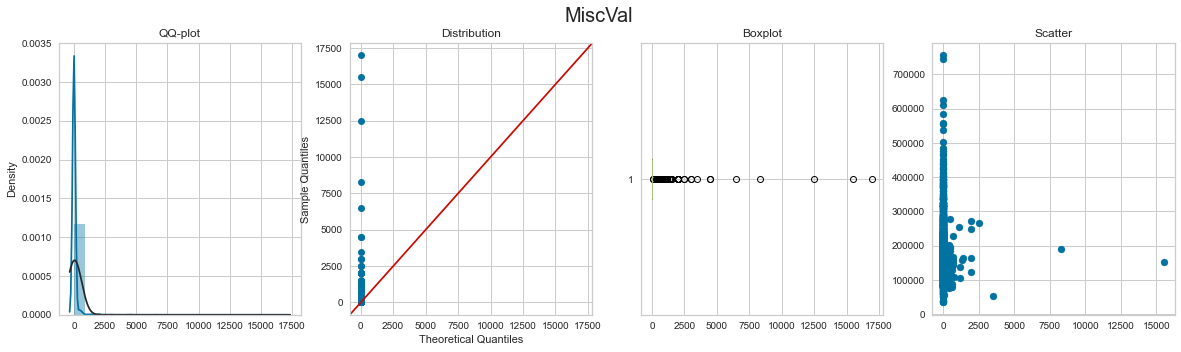

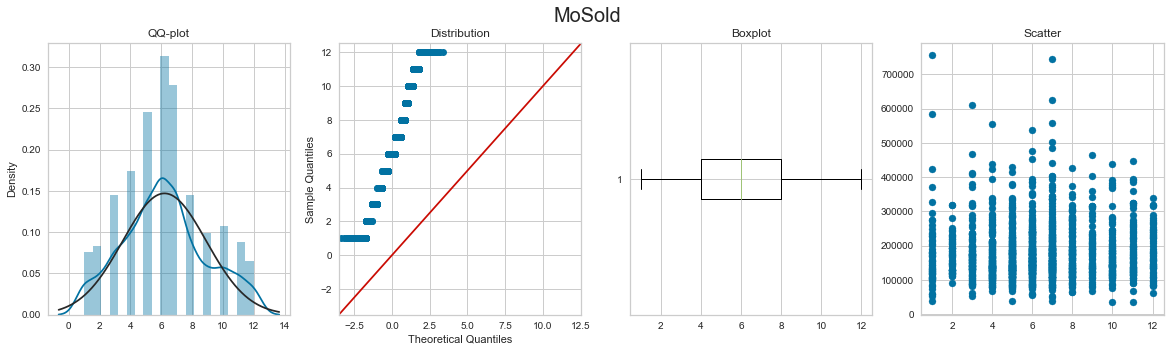

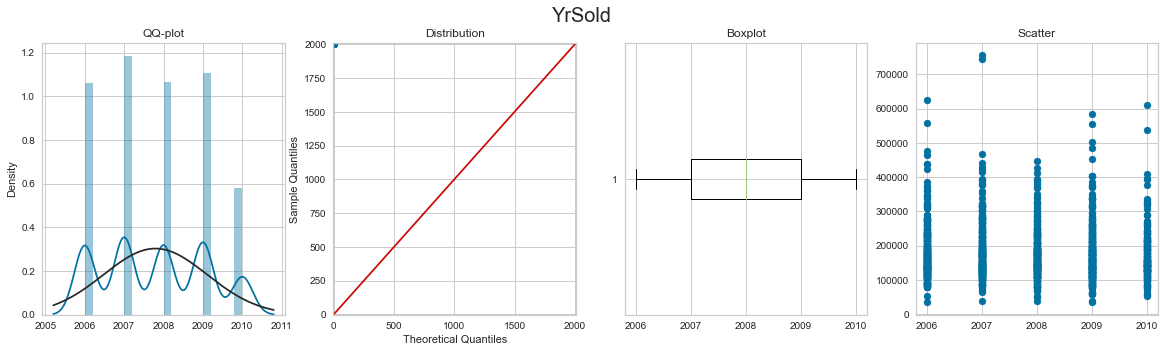

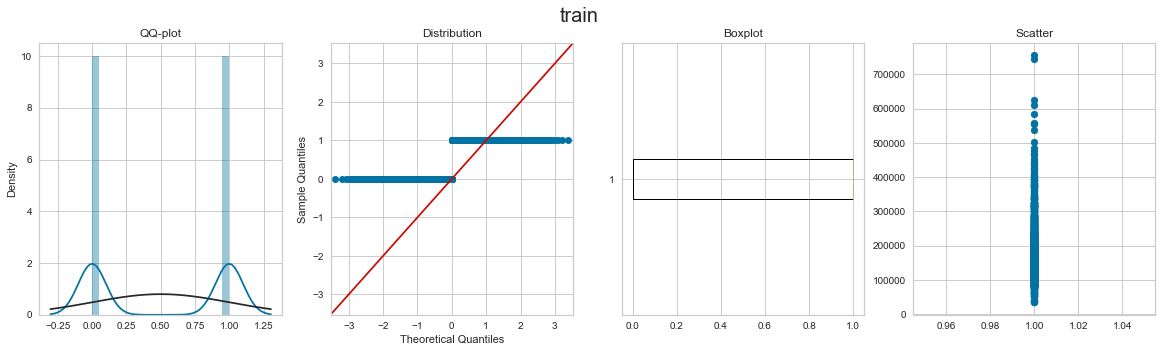

In [35]:
#get all info about numerical data
for col in df.select_dtypes(exclude='object').drop('SalePrice', axis=1):
    get_num_info(df[col], title=col, target=df['SalePrice'])

In [36]:
columns_ejection=['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', \
                '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', \
                'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',\
                'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',\
                'ScreenPorch', 'PoolArea', 'MiscVal']

In [37]:
#remove enjection
for x in df[columns_ejection]:
    q75,q25 = np.percentile(df.loc[:,x],[90,10])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    df.loc[df[x] < min,x] = df[x].min()
    df.loc[df[x] > max,x] = df[x].max()

In [38]:
# fix 2207 on 2007
df['GarageYrBlt'] = df['GarageYrBlt'].apply(lambda x: 2007 if x == 2207 else x)

In [39]:
df[['YearRemodAdd', 'YearBuilt']][df['YearRemodAdd'].index == 1876]

,YearRemodAdd,YearBuilt
1876,2001,2002


In [40]:
df['YearRemodAdd'][df['YearRemodAdd'].index == 1876] = 2002

### Generate new features<a class="anchor" id="2.2.2-bullet"></a>
[back to contents](#0-bullet)

In [41]:
df['TotalBath'] = df['BsmtFullBath'] + df['BsmtHalfBath'] * 0.5 + df['FullBath'] + df['HalfBath'] * 0.5
df['TotalBsmtSF'] = df['TotalBsmtSF'] + df['BsmtFinSF1'] + df['BsmtFinSF2']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['Total_Porch_SF'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']

df['TimeLastRemodAdd'] = df['YearRemodAdd'] - df['YearBuilt'] 

In [42]:
df['YearBuilt'] = 2017 - df['YearBuilt']
df['GarageYrBlt'] = 2017 - df['GarageYrBlt']

In [43]:
# the building class
df['MSSubClass'] = df['MSSubClass'].apply(str)
df['OverallCond'] = df['OverallCond'].astype(str)
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

In [44]:
def get_uniq_values(df):
    return pd.DataFrame(df.apply(pd.unique)).rename(columns={0:'Unique values'})

In [45]:
get_uniq_values(df.select_dtypes(exclude='object'))['Unique values']\
.apply(lambda x: len(x)).sort_values().head(20)

3SsnPorch         2
BsmtHalfBath      2
train             2
LowQualFinSF      2
MiscVal           2
PoolArea          2
ScreenPorch       2
HalfBath          3
KitchenAbvGr      3
Fireplaces        4
BsmtFullBath      4
FullBath          5
GarageCars        6
BedroomAbvGr      8
OverallQual      10
TotalBath        11
TotRmsAbvGrd     12
YearRemodAdd     61
GarageYrBlt     102
BsmtFinSF2      112
Name: Unique values, dtype: int64

In [46]:
for feature in get_uniq_values(df.select_dtypes(exclude='object'))['Unique values']\
.apply(lambda x: len(x)).sort_values().head(11).index:df[feature] = df[feature].apply(str)

In [47]:
# drop features
df.drop(['1stFlrSF'], axis = 1, inplace=True)
df.drop('YearRemodAdd', axis = 1, inplace=True)
df.drop(['GarageArea', 'PoolArea', '2ndFlrSF', 'Fireplaces'], axis=1, inplace=True)
df.drop(['BedroomAbvGr', 'KitchenAbvGr'], axis = 1, inplace=True)

## Pretrain to fill missed target values<a class="anchor" id="3-bullet"></a>
[back to contents](#0-bullet)

In [48]:
#make type "float64"
df['train'] = df['train'].astype('float64')

In [49]:
#create variable without objects
df_num=df.select_dtypes(exclude='object')
df_num.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,GrLivArea,...,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,SalePrice,train,TotalBath,TotalSF,Total_Porch_SF,TimeLastRemodAdd
0,65.0,8450,7,14,196.0,706.0,0.0,150.0,1562.0,1710,...,2.0,0,61,0,208500.0,1.0,3.5,3272.0,61,0
1,80.0,9600,6,41,0.0,978.0,0.0,284.0,2240.0,1262,...,2.0,298,0,0,181500.0,1.0,3.0,3502.0,298,0
2,68.0,11250,7,16,162.0,486.0,0.0,434.0,1406.0,1786,...,2.0,0,42,0,223500.0,1.0,3.5,3192.0,42,1
3,60.0,9550,7,102,0.0,216.0,0.0,540.0,972.0,1717,...,3.0,0,35,272,140000.0,1.0,2.0,2689.0,307,55
4,84.0,14260,8,17,350.0,655.0,0.0,490.0,1800.0,2198,...,3.0,192,84,0,250000.0,1.0,3.5,3998.0,276,0


In [50]:
x_pre, y_pre = df_num[df_num['train'].isin([1])].drop('SalePrice', axis=1).to_numpy(),\
df_num[df_num['train'].isin([1])].select_dtypes(exclude='object')['SalePrice'].to_numpy()
y_pre = np.log(y_pre)
x_test_pre = df_num[df_num['train'].isin([0])].to_numpy()

In [51]:
# make predictions
cat_pre = CatBoostRegressor(depth=5, learning_rate = .1, iterations=300, silent = True, )

cat_pre.fit(x_pre,y_pre)

print('R2',r2_score(y_pre,cat_pre.predict(x_pre)))

R2 0.9630179550955339


In [52]:
df_test_=df[1460:]

In [53]:
# fill nan
df_test_['SalePrice']=np.exp(cat_pre.predict(x_test_pre))

In [54]:
df=pd.concat([df[:1460], df_test_])

## Clustering<a class="anchor" id="4-bullet"></a>
[back to contents](#0-bullet)

In [55]:
X = df.select_dtypes(exclude='object').drop(['SalePrice'], axis=1)
X = StandardScaler().fit_transform(X)

In [56]:
pca = PCA(n_components=2)

In [57]:
X_pca = pca.fit_transform(X)

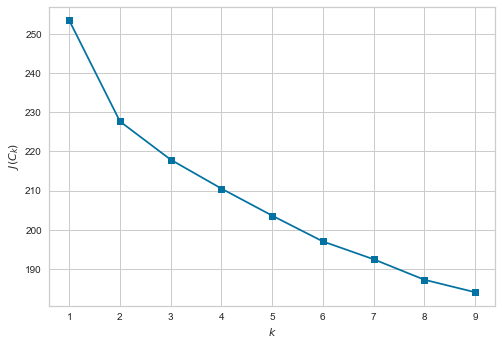

In [58]:
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 10), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

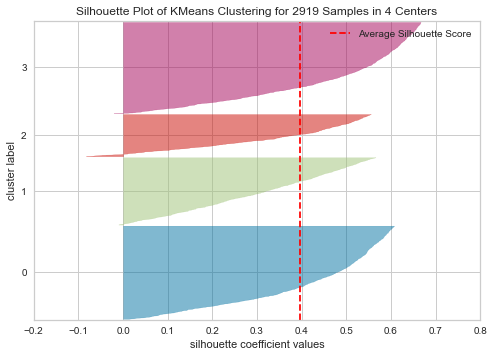

In [59]:
from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X_pca)
visualizer.show();

In [60]:
km = KMeans(4)
km.fit(X_pca)

KMeans(n_clusters=4)

In [61]:
op = km.labels_
df['classter'] = op

## Label encoding<a class="anchor" id="5-bullet"></a>
[back to contents](#0-bullet)

In [62]:
df = df.drop('train', axis=1)

In [63]:
def fillna(df):
    for i in df.columns:
        if df[i].dtype == 'O': df[i] = df[i].fillna('missed')
        else: df[i] = df[i].fillna(0)
    return df

In [64]:
# OneHotEncoding
for i in df.columns:
    if df[i].dtype == 'O' and i != 'SalePrice':
        df = pd.concat([df, pd.get_dummies(df[i], prefix=(i+'M'))], axis=1)
        df.drop(i, axis=1, inplace=True)
# Fill none values
df = fillna(df)

## Model<a class="anchor" id="6-bullet"></a>
[back to contents](#0-bullet)

In [65]:
train, test = df.loc[:1459], df.loc[1460:].drop(['SalePrice'], axis=1)

In [66]:
X, Y = train[test.columns.to_list()].to_numpy(), train['SalePrice'].to_numpy()
Y = np.log(Y)
X_test = test.to_numpy()
Y_test = df.loc[1460:]['SalePrice'].to_numpy()

In [203]:
GBR = GradientBoostingRegressor(n_estimators=3000, 
                            learning_rate=0.05, 
                            max_depth=4, 
                            max_features='sqrt', 
                            min_samples_leaf=15, 
                            min_samples_split=10, 
                            loss='huber', 
                            random_state =42)  
GBR.fit(X,Y)
print('R2',r2_score(Y,GBR.predict(X)))
GBR_result = np.exp(GBR.predict(X_test))

R2 0.977944915610998


In [204]:
lgbm = LGBMRegressor(objective='regression',num_leaves=4, learning_rate=0.01, 
                         n_estimators=5000,max_bin=200, bagging_fraction=0.75,
                         bagging_freq=5, bagging_seed=7,feature_fraction=0.2,
                         feature_fraction_seed=7, verbose=-1)
lgbm.fit(X,Y)
print('R2',r2_score(Y,lgbm.predict(X)))
lgbm_result = np.exp(lgbm.predict(X_test))

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
R2 0.9563973682856651


In [205]:
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=3000,
                       max_depth=3,
                       gamma=0,
                       colsample_bytree=0.7,
                       scale_pos_weight=1,
                       reg_alpha=0.00006,
                       objective='reg:linear')
xgboost.fit(X,Y)
print('R2',r2_score(Y,xgboost.predict(X)))
xgboost_result = np.exp(xgboost.predict(X_test))

R2 0.977857926932619


In [235]:
cat = CatBoostRegressor(iterations = 10000, learning_rate = .08, eval_metric = 'RMSE',
                        random_seed = 42, logging_level=  'Silent', loss_function = 'RMSE',
                        od_type = 'Iter', od_wait = 1000, one_hot_max_size = 20,
                        l2_leaf_reg = 100, depth = 3, rsm = .6,
                        random_strength = 2, bagging_temperature = 10)
cat.fit(X,Y)
print('R2',r2_score(Y,cat.predict(X)))
cat_result = np.exp(cat.predict(X_test))

R2 0.987011824426803


### Stacking

In [227]:
stack = StackingRegressor(estimators = [('gbr', GBR), ('cat', cat)])

stack.fit(X,Y)
print('R2',r2_score(Y,stack.predict(X)))
stack_result = np.exp(stack.predict(X_test))

R2 0.9861476042193421


### Blending

In [230]:
def blend(x):
    return (0.5 * stack.predict(x) + 0.5 * cat.predict(x))

blend1 = blend(X)
print('R2',r2_score(Y, blend1))

R2 0.9875076146677537


In [232]:
def blend_test(x):
    return np.exp(0.5 * stack.predict(x) + 0.5 * cat.predict(x))
blend1_result_test = blend_test(X_test)

## Submit<a class="anchor" id="7-bullet"></a>
[back to contents](#0-bullet)

In [236]:
sub = pd.DataFrame()
sub['Id'] = range(1461, 2920)
sub['SalePrice'] = blend1_result_test

In [237]:
sub.to_csv('submission_blend1_result_test.csv', header=True, index=False)